In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/char_transformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [ ]:
# Enable autoreload of local Python modules (e.g., models)
#%load_ext autoreload
#%autoreload 2

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import numpy as np
import optax
import time
from functools import partial
import matplotlib.pyplot as plt

# ✅ Mixed precision on GPU (T4 runs fastest with this)
jax.config.update("jax_default_dtype_bits", "32")
jax.default_matmul_precision("bfloat16")

# local imports
import models.final as models_full
import models.decoder_4 as decoder_4
import util.generation as generation


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# initialize the jax random key
key = jax.random.key(0)

In [ ]:
# verify that the code is being run on Colab's GPU
print(jax.default_backend())

tpu


# Load data

In [ ]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [ ]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [ ]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [ ]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

it in the chamber which can only seat four two seven of the six four six members members who arrive late must stand near the ent

of education did not fulfil the academic efficiency that match with the spirit of age after the first world war things changed a

tory despite the restoration of one six six zero was followed up by the glorious revolution of one six eight eight drove from po

ieve that god has established a new covenant with people and that this new covenant is established in an additional set of books

le mekong river at neak luong phumi prek khsay tonle bet sre ambel kampong cham and stoeng treng were restored in one nine eight



# Create a basic Transformer model

In [ ]:
import jax.random as random
import jax

vocab_size = len(char_set)
d_model = 384
n_layers = 6
n_heads = 8
mlp_ratio = 4

# Regularization: stronger dropout to reduce memorization
dropout_rate = 0.05   # increased from 0.1 -> 0.3
attn_dropout = 0.05  # increased attention dropout

use_swiglu = True
tie_embeddings = True
max_len = 256

model_1 = decoder_4.DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    max_len=max_len,
    mlp_ratio=mlp_ratio,
    dropout_rate=dropout_rate,
    attn_dropout=attn_dropout,
    use_swiglu=use_swiglu,
    tie_embeddings=tie_embeddings,
)
model_2 = models_full.DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    max_len=max_len,
    mlp_ratio=mlp_ratio,
    dropout_rate=dropout_rate,
    attn_dropout=attn_dropout,
    use_swiglu=use_swiglu,
    tie_embeddings=tie_embeddings,
)

In [ ]:
def create_train_state(model, rng=jax.random.key(0), vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    if type(model) == type:
      base_model = model(vocab_size, d_model, n_layers, n_heads, max_len)
    else:
      base_model = model
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(8, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = base_model.init({"params": rng, "dropout": rng}, dummy, deterministic=True)["params"]
    return base_model, params

In [ ]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [ ]:
# sanity check: create a batch of data & run a forward pass
'''
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)
'''

'\nB, T = 4, 32\nbatch = jax.random.randint(\n    key=key,\n    shape=(B, T), minval=0, maxval=len(char_set))\nlogits = model.apply({"params": params}, batch)\n\nprint("batch shape:", batch.shape)  # (B, T)\nprint("logits shape:", logits.shape)  # (B, T, vocab_size)\n'

# Loss function

In [ ]:
# --- Loss and metrics (JIT-friendly) ---
import jax.nn as jnn
from functools import partial

label_smoothing = 0.01  # set small value like 0.1 if you want smoothing

def loss_and_metrics(logits, targets, gamma=2.0, alpha=0.25, label_smoothing=0.0):
    vocab_size = logits.shape[-1]
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)

    # one-hot targets (for label smoothing)
    if label_smoothing > 0.0:
        one_hot = jnn.one_hot(targets_flat, vocab_size)
        smooth = one_hot * (1.0 - label_smoothing) + label_smoothing / vocab_size
        log_probs = jnn.log_softmax(logits_flat)
        loss = -jnp.sum(smooth * log_probs, axis=-1).mean()
    else:
        # standard cross-entropy
        loss = optax.softmax_cross_entropy_with_integer_labels(logits_flat, targets_flat).mean()

    # compute token-level accuracy
    preds = jnp.argmax(logits, axis=-1)
    acc = (preds == targets).mean()

    # ✅ compute last character accuracy (final token per sequence) // NEW
    last_token_acc = (preds[:, -1] == targets[:, -1]).mean()

     # ✅ include it in the returned metrics
    return loss, {
        "loss": loss,
        "acc": acc,
        "acc_last": last_token_acc, # // NEW
    }

# Optimization step:

In [ ]:
@jax.jit
def train_step(params, opt_state, x, y, *, tx):
    """
    Performs one optimization step.
    rng: PRNGKey passed in; we'll split it to produce a dropout key used for the forward pass.
    Returns: new_params, new_opt_state, metrics
    """
    deterministic = True
    # produce a fresh subkey for randomness (dropout)
    rng, dropout_rng = jax.random.split(rng)
    def loss_fn(p):
        logits = model.apply({"params": p}, x, deterministic=False, rngs={"dropout": rng})
        loss, mets = loss_and_metrics(logits, y, label_smoothing=0.01)
        return loss, mets
    (loss, mets), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, mets

train_step = jax.jit(train_step, static_argnames=("tx",))


# Batch creation:

In [ ]:
import jax
import jax.numpy as jnp

def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [ ]:
# create a batch from the training data


In [ ]:
# preload / move data to GPU once (avoids CPU-GPU copy per step)
train_text_int = jax.device_put(train_text_int)
test_text_int  = jax.device_put(test_text_int)

# Optimizer creation:

In [ ]:
# --- Optimizer and learning rate schedule ---
import optax

tx1 = lambda peak_lr, end_lr: optax.chain(
    optax.clip_by_global_norm(1.0),            # gradient clipping
    optax.adamw(learning_rate=optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=peak_lr,
    warmup_steps=300,
    decay_steps=max(1, 10_000 - 300),
    end_value=end_lr,
    ), weight_decay=0.1)
)

tx2 = lambda lr: optax.chain(
  optax.clip_by_global_norm(1.0),            # gradient clipping
  optax.adamw(learning_rate=lr)
)

In [ ]:
def train(model, params, tx, B=128, T=128, niter=10_000, tl=10*60, label_smoothing = 0.005):
    opt_state = tx.init(params)

    def train_step(params, opt_state, x, y, *, tx):
        """
        Performs one optimization step.
        rng: PRNGKey passed in; we'll split it to produce a dropout key used for the forward pass.
        Returns: new_params, new_opt_state, metrics
        """
        deterministic = True
        # produce a fresh subkey for randomness (dropout)
        rng, dropout_rng = jax.random.split(jax.random.key(0))
        def loss_fn(p):
            logits = model.apply({"params": p}, x, deterministic=False, rngs={"dropout": rng})
            loss, mets = loss_and_metrics(logits, y, label_smoothing=label_smoothing)
            return loss, mets
        (loss, mets), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        updates, new_opt_state = tx.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, mets

    train_step = jax.jit(train_step, static_argnames=("tx",))

    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    it = 0
    while it < niter and time.time() - time_start < tl:
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx=tx)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = B * 4, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            if it % (niter // 5) == 0 or it == niter - 1:
              print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
              print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
              print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
              print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
              print()
        it += 1
    return loss_history, time_history, loss_test_history, time_test_history



In [ ]:
model_1, params_1 = create_train_state(model_1)
model_2, params_2 = create_train_state(model_2)

print(f"base model param_count: {count_params(params_1):_}")
print(f"full model param_count: {count_params(params_2):_}")

base model param_count: 14_304_384
full model param_count: 14_295_168


In [ ]:
import csv

def csv_writing(lh, th, lth, tth, suffix):
    # Training metrics
    train_file_name = f"./data/train_loss_{suffix}.csv"
    with open(train_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss"])  # header
        writer.writerows(zip(th, lh))

    test_file_name = f"./data/test_loss_{suffix}.csv"
    # Test metrics
    with open(test_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss"])  # header
        writer.writerows(zip(tth, lth))

    print("csv files saved:", train_file_name, test_file_name)

In [ ]:
peak, end = 5e-4, 5e-5
lh1, th1, lth1, tth1 = train(model_1, params_1, tx1(peak, end))
csv_writing(lh1, th1, lth1, tth1, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}")

iteration 0  time: 72.9 seconds
	 	 loss(train :: test): 3.3711 :: 3.3720
	 	 accuracy (train :: test): 3.6% :: 3.1%
	 	 accuracy (last character) (train :: test): 4.7% :: 2.3%

iteration 2_000  time: 265.5 seconds
	 	 loss(train :: test): 1.3101 :: 1.2964
	 	 accuracy (train :: test): 59.5% :: 59.5%
	 	 accuracy (last character) (train :: test): 63.3% :: 59.2%

csv files saved: ./data/train_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0005, 5e-05).csv ./data/test_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0005, 5e-05).csv


In [ ]:
lh2, th2, lth2, tth2 = train(model_2, params_2, tx1(peak, end))
csv_writing(lh2, th2, lth2, tth2, f"Full (cosine decay)_LR{(peak, end)}")

iteration 0  time: 62.7 seconds
	 	 loss(train :: test): 3.3737 :: 3.3612
	 	 accuracy (train :: test): 3.4% :: 3.8%
	 	 accuracy (last character) (train :: test): 6.2% :: 2.7%

iteration 2_000  time: 248.2 seconds
	 	 loss(train :: test): 1.3291 :: 1.2931
	 	 accuracy (train :: test): 59.6% :: 59.5%
	 	 accuracy (last character) (train :: test): 67.2% :: 59.8%

csv files saved: ./data/train_loss_Full (cosine decay)_LR(0.0005, 5e-05).csv ./data/test_loss_Full (cosine decay)_LR(0.0005, 5e-05).csv


In [ ]:
adamw_lr = 1e-4
lh3, th3, lth3, tth3 = train(model_2, params_2, tx2(adamw_lr))
csv_writing(lh3, th3, lth3, tth3, f"Full (adamW)_LR({adamw_lr})")

iteration 0  time: 63.2 seconds
	 	 loss(train :: test): 3.3696 :: 3.0813
	 	 accuracy (train :: test): 3.0% :: 16.5%
	 	 accuracy (last character) (train :: test): 0.8% :: 19.9%

iteration 2_000  time: 248.8 seconds
	 	 loss(train :: test): 1.5187 :: 1.4274
	 	 accuracy (train :: test): 53.7% :: 55.8%
	 	 accuracy (last character) (train :: test): 53.9% :: 55.7%

csv files saved: ./data/train_loss_Full (adamW)_LR(0.0001).csv ./data/test_loss_Full (adamW)_LR(0.0001).csv


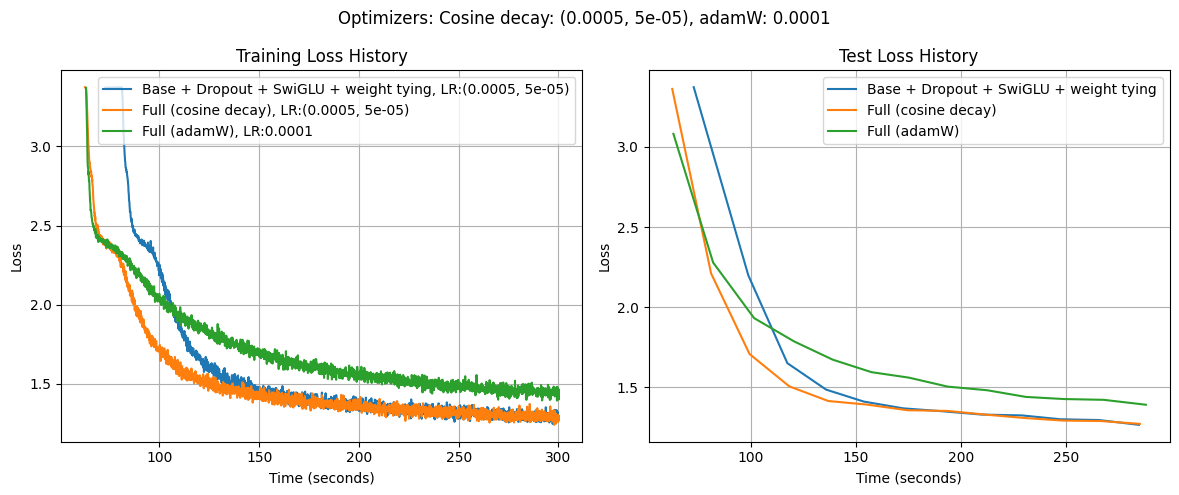

Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm


In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th1, lh1, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th2, lh2, label=f"Full (cosine decay), LR:{(peak, end)}")
plt.plot(th3, lh3, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth1, lth1, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth2, lth2, label="Full (cosine decay)")
plt.plot(tth3, lth3, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, adamW: {adamw_lr}")

plt.tight_layout()
plt.savefig('tff_1.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
peak, end = 5e-4, 5e-5
lh4, th4, lth4, tth4 = train(model_1, params_1, tx1(peak, end), label_smoothing=0)
csv_writing(lh4, th4, lth4, tth4, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}_no_smoothing")

iteration 0  time: 70.0 seconds
	 	 loss(train :: test): 3.3696 :: 3.3728
	 	 accuracy (train :: test): 2.9% :: 3.2%
	 	 accuracy (last character) (train :: test): 3.9% :: 2.5%

iteration 2_000  time: 260.4 seconds
	 	 loss(train :: test): 1.2741 :: 1.2808
	 	 accuracy (train :: test): 60.1% :: 59.7%
	 	 accuracy (last character) (train :: test): 63.3% :: 60.0%

csv files saved: ./data/train_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0005, 5e-05)_no_smoothing.csv ./data/test_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0005, 5e-05)_no_smoothing.csv


In [ ]:
lh5, th5, lth5, tth5 = train(model_2, params_2, tx1(peak, end),label_smoothing=0)
csv_writing(lh5, th5, lth5, tth5, f"Full (cosine decay)_LR{(peak, end)}_no_smoothing")

iteration 0  time: 63.9 seconds
	 	 loss(train :: test): 3.3685 :: 3.3720
	 	 accuracy (train :: test): 3.4% :: 3.7%
	 	 accuracy (last character) (train :: test): 6.2% :: 2.7%

iteration 2_000  time: 251.5 seconds
	 	 loss(train :: test): 1.2937 :: 1.2993
	 	 accuracy (train :: test): 59.5% :: 59.3%
	 	 accuracy (last character) (train :: test): 60.9% :: 59.8%

csv files saved: ./data/train_loss_Full (cosine decay)_LR(0.0005, 5e-05)_no_smoothing.csv ./data/test_loss_Full (cosine decay)_LR(0.0005, 5e-05)_no_smoothing.csv


In [ ]:
adamw_lr = 1e-4
lh6, th6, lth6, tth6 = train(model_2, params_2, tx2(adamw_lr), label_smoothing=0)
csv_writing(lh6, th6, lth6, tth6, f"Full (adamW)_LR({adamw_lr})_no_smoothing")

iteration 0  time: 66.5 seconds
	 	 loss(train :: test): 3.3721 :: 3.0823
	 	 accuracy (train :: test): 3.2% :: 16.4%
	 	 accuracy (last character) (train :: test): 2.3% :: 14.8%

iteration 2_000  time: 256.2 seconds
	 	 loss(train :: test): 1.4425 :: 1.4426
	 	 accuracy (train :: test): 55.1% :: 55.6%
	 	 accuracy (last character) (train :: test): 46.1% :: 52.1%

csv files saved: ./data/train_loss_Full (adamW)_LR(0.0001)_no_smoothing.csv ./data/test_loss_Full (adamW)_LR(0.0001)_no_smoothing.csv


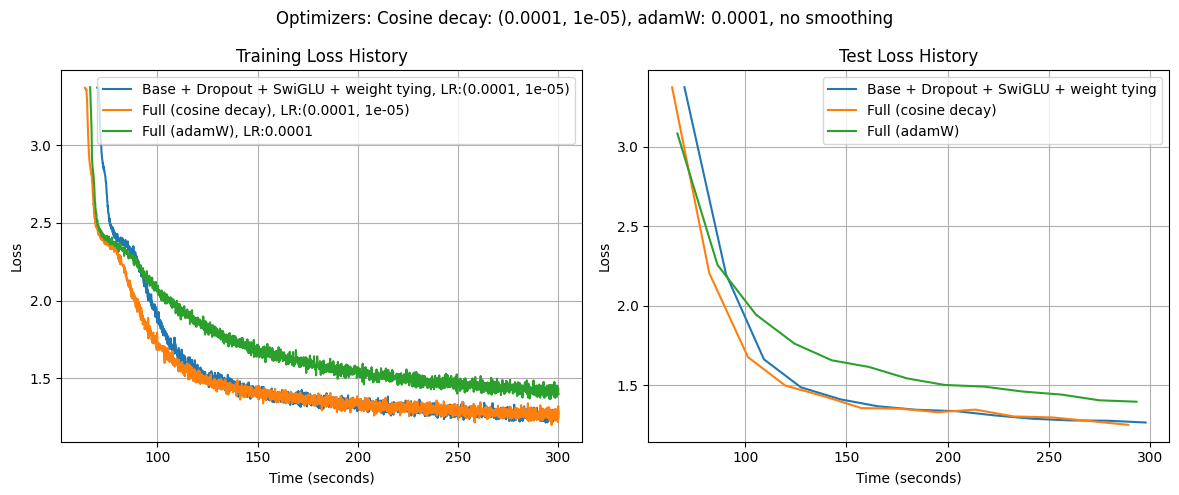

Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm


In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th4, lh4, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th5, lh5, label=f"Full (cosine decay), LR:{(peak, end)}")
plt.plot(th6, lh6, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth4, lth4, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth5, lth5, label="Full (cosine decay)")
plt.plot(tth6, lth6, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, adamW: {adamw_lr}, no smoothing")

plt.tight_layout()
plt.savefig('tff_2.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
peak, end = 1e-4, 1e-5
lh7, th7, lth7, tth7 = train(model_1, params_1, tx1(peak, end))
csv_writing(lh7, th7, lth7, tth7, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}")

iteration 0  time: 70.8 seconds
	 	 loss(train :: test): 3.3747 :: 3.3665
	 	 accuracy (train :: test): 3.2% :: 3.3%
	 	 accuracy (last character) (train :: test): 2.3% :: 4.3%

iteration 2_000  time: 258.7 seconds
	 	 loss(train :: test): 1.5141 :: 1.4424
	 	 accuracy (train :: test): 54.1% :: 55.5%
	 	 accuracy (last character) (train :: test): 53.1% :: 54.1%

csv files saved: ./data/train_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0001, 1e-05).csv ./data/test_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0001, 1e-05).csv


In [ ]:
lh8, th8, lth8, tth8 = train(model_2, params_2, tx1(peak, end))
csv_writing(lh8, th8, lth8, tth8, f"Full (cosine decay)_LR{(peak, end)}")

iteration 0  time: 63.8 seconds
	 	 loss(train :: test): 3.3688 :: 3.3668
	 	 accuracy (train :: test): 3.7% :: 3.6%
	 	 accuracy (last character) (train :: test): 0.8% :: 2.5%

iteration 2_000  time: 252.3 seconds
	 	 loss(train :: test): 1.4901 :: 1.4275
	 	 accuracy (train :: test): 54.4% :: 55.9%
	 	 accuracy (last character) (train :: test): 60.2% :: 49.8%

csv files saved: ./data/train_loss_Full (cosine decay)_LR(0.0001, 1e-05).csv ./data/test_loss_Full (cosine decay)_LR(0.0001, 1e-05).csv


In [ ]:
adamw_lr = 5e-5
lh9, th9, lth9, tth9 = train(model_2, params_2, tx2(adamw_lr))
csv_writing(lh9, th9, lth9, tth9, f"Full (adamW)_LR({adamw_lr})")

iteration 0  time: 63.4 seconds
	 	 loss(train :: test): 3.3734 :: 3.1731
	 	 accuracy (train :: test): 3.7% :: 14.1%
	 	 accuracy (last character) (train :: test): 2.3% :: 13.9%

iteration 2_000  time: 248.0 seconds
	 	 loss(train :: test): 1.6184 :: 1.5587
	 	 accuracy (train :: test): 50.4% :: 52.4%
	 	 accuracy (last character) (train :: test): 46.9% :: 53.1%

csv files saved: ./data/train_loss_Full (adamW)_LR(5e-05).csv ./data/test_loss_Full (adamW)_LR(5e-05).csv


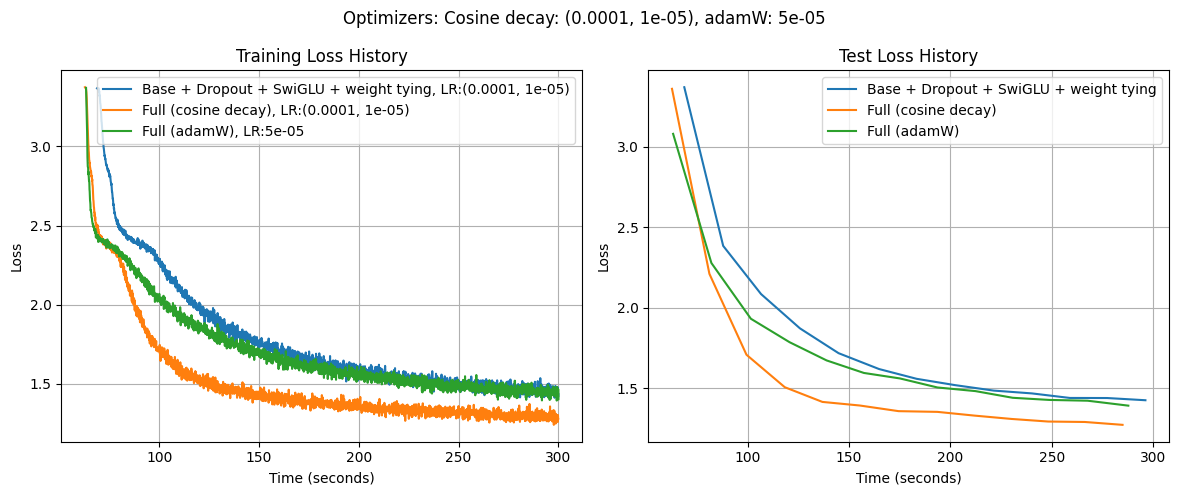

Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm


In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th7, lh7, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th8, lh8, label=f"Full (cosine decay), LR:{(peak, end)}")
plt.plot(th9, lh9, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth7, lth7, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth8, lth8, label="Full (cosine decay)")
plt.plot(tth9, lth9, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, adamW: {adamw_lr}")

plt.tight_layout()
plt.savefig('tff_3.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
peak, end = 1e-4, 1e-5
lh_a, th_a, lth_a, tth_a = train(model_1, params_1, tx1(peak, end), label_smoothing=0)
csv_writing(lh_a, th_a, lth_a, tth_a, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}_no_smoothing")

iteration 0  time: 72.6 seconds
	 	 loss(train :: test): 3.3653 :: 3.3720
	 	 accuracy (train :: test): 3.4% :: 3.0%
	 	 accuracy (last character) (train :: test): 2.3% :: 3.9%

iteration 2_000  time: 262.5 seconds
	 	 loss(train :: test): 1.4505 :: 1.4174
	 	 accuracy (train :: test): 55.0% :: 56.1%
	 	 accuracy (last character) (train :: test): 57.8% :: 55.9%

csv files saved: ./data/train_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0001, 1e-05)_no_smoothing.csv ./data/test_loss_(Base + Dropout + SwiGLU + weight tying)_LR(0.0001, 1e-05)_no_smoothing.csv


In [ ]:
lh_b, th_b, lth_b, tth_b = train(model_2, params_2, tx1(peak, end), label_smoothing=0)
csv_writing(lh_b, th_b, lth_b, tth_b, f"Full (cosine decay)_LR{(peak, end)}_no_smoothing")

iteration 0  time: 67.6 seconds
	 	 loss(train :: test): 3.3735 :: 3.3623
	 	 accuracy (train :: test): 3.4% :: 3.6%
	 	 accuracy (last character) (train :: test): 3.1% :: 2.7%

iteration 2_000  time: 255.5 seconds
	 	 loss(train :: test): 1.4514 :: 1.4488
	 	 accuracy (train :: test): 55.2% :: 55.2%
	 	 accuracy (last character) (train :: test): 59.4% :: 56.1%

csv files saved: ./data/train_loss_Full (cosine decay)_LR(0.0001, 1e-05)_no_smoothing.csv ./data/test_loss_Full (cosine decay)_LR(0.0001, 1e-05)_no_smoothing.csv


In [ ]:
adamw_lr = 5e-5
lh_c, th_c, lth_c, tth_c = train(model_2, params_2, tx2(adamw_lr), label_smoothing=0)
csv_writing(lh_c, th_c, lth_c, tth_c, f"Full (adamW)_LR({adamw_lr})_no_smoothing")

iteration 0  time: 66.3 seconds
	 	 loss(train :: test): 3.3721 :: 3.1758
	 	 accuracy (train :: test): 3.5% :: 13.9%
	 	 accuracy (last character) (train :: test): 3.9% :: 14.8%

iteration 2_000  time: 256.7 seconds
	 	 loss(train :: test): 1.6019 :: 1.5524
	 	 accuracy (train :: test): 51.3% :: 52.6%
	 	 accuracy (last character) (train :: test): 53.9% :: 55.9%

csv files saved: ./data/train_loss_Full (adamW)_LR(5e-05)_no_smoothing.csv ./data/test_loss_Full (adamW)_LR(5e-05)_no_smoothing.csv


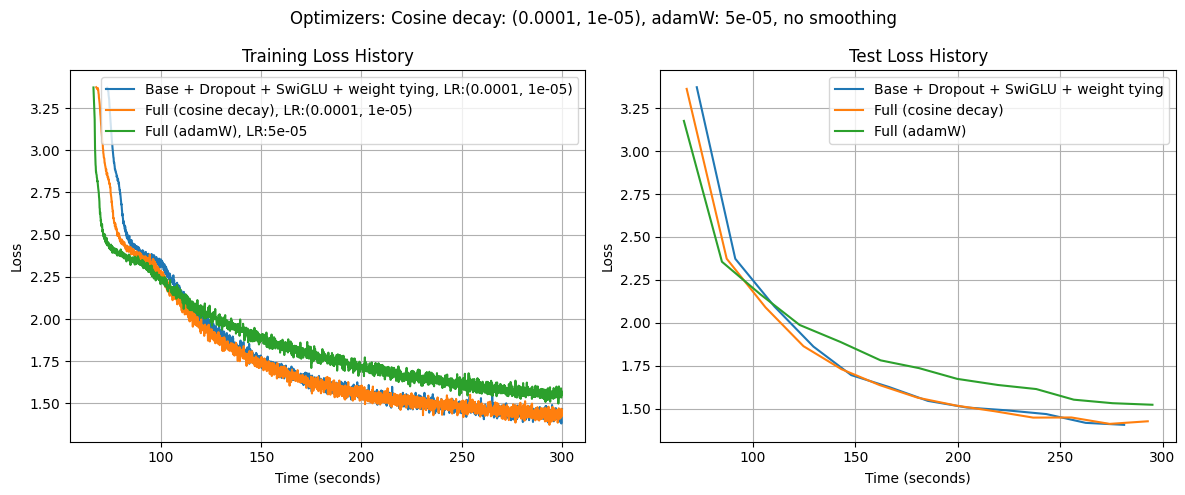

Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm


In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th_a, lh_a, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th_b, lh_b, label=f"Full (cosine decay), LR:{(peak, end)}")
plt.plot(th_c, lh_c, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth_a, lth_a, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth_b, lth_b, label="Full (cosine decay)")
plt.plot(tth_c, lth_c, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, adamW: {adamw_lr}, no smoothing")

plt.tight_layout()
plt.savefig('tff_4.png', bbox_inches='tight')
plt.show()

print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")
